In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import socket, struct
import netaddr

import xxhash
%matplotlib inline

In [2]:
tp = pd.read_csv('capture20110818.pcap.netflow.labeled.csv', chunksize=1000)
df = pd.concat(tp, ignore_index=True)

# preprocessing
ips = df['SrcIPAddr:Port'].str.split(':')
df['SrcIPAddr'] = ips.str[0]
df['SrcIPPort'] = ips.str[-1]
ips = df['DstIPAddr:Port'].str.split(':')
df['DstIPAddr'] = ips.str[0]
df['DstIPPort'] = ips.str[-1]

df = df[df['SrcIPAddr']!='147.32.84.229']

most_freq = df.groupby(['SrcIPAddr'])['SrcIPAddr'].agg({'Frequency':'count'}).sort_values(['Frequency'], ascending=False).head(10)
most_freq_ips = list(zip(most_freq.index, np.reshape(most_freq.values, -1)))
print(most_freq_ips)

df.head()

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


[('147.32.80.9', 109284), ('147.32.84.59', 101036), ('147.32.84.138', 49379), ('147.32.84.118', 12724), ('147.32.85.25', 10381), ('147.32.80.13', 9064), ('147.32.84.95', 8592), ('147.32.86.20', 8236), ('147.32.85.26', 7416), ('147.32.86.165', 6438)]


,Date,Flow_start,Durat,Prot,SrcIPAddr:Port,tmp,DstIPAddr:Port,Flags,Tos,Packets,Bytes,Flows,Label,Labels,SrcIPAddr,SrcIPPort,DstIPAddr,DstIPPort
0,2011-08-18,10:19:13.328,0.002,TCP,147.32.86.166:33426,->,212.24.150.110:25443,FRPA_,0,4,321,1,Background,NaN,147.32.86.166,33426,212.24.150.110,25443
1,2011-08-18,10:19:13.328,4.995,UDP,82.39.2.249:41915,->,147.32.84.59:43087,INT,0,617,40095,1,Background,NaN,82.39.2.249,41915,147.32.84.59,43087
2,2011-08-18,10:19:13.329,4.996,UDP,147.32.84.59:43087,->,82.39.2.249:41915,INT,0,1290,1909200,1,Background,NaN,147.32.84.59,43087,82.39.2.249,41915
3,2011-08-18,10:19:13.330,0.000,TCP,147.32.86.166:42020,->,147.32.192.34:993,A_,0,1,66,1,Background,NaN,147.32.86.166,42020,147.32.192.34,993
4,2011-08-18,10:19:13.330,0.000,TCP,212.24.150.110:25443,->,147.32.86.166:33426,FPA_,0,2,169,1,Background,NaN,212.24.150.110,25443,147.32.86.166,33426


In [3]:
confidence_interval = 0.99
error_rate = 0.001
w = int(np.ceil(2/error_rate)) #amount of 'counters' within a hash function
d = int(np.ceil(-np.log(1-confidence_interval)/np.log(2))) #amount of hash functions

print(w, d)


def update_wd(_hash,loc):
    wd[_hash][loc] = wd[_hash][loc] + 1

2000 7


In [4]:
wd = np.zeros((d, w))
#create the count min table
for i in range(d):
    #compute hashes of each source ip
    df['hash' + str(i)] = df['SrcIPAddr'].apply(lambda row: xxhash.xxh32(row, seed=i).intdigest())
    #update row in count min table for these hashes 
    df['hash' + str(i)].apply(lambda row: update_wd(i,row%w))
    
    
df.head()

,Date,Flow_start,Durat,Prot,SrcIPAddr:Port,tmp,DstIPAddr:Port,Flags,Tos,Packets,...,SrcIPPort,DstIPAddr,DstIPPort,hash0,hash1,hash2,hash3,hash4,hash5,hash6
0,2011-08-18,10:19:13.328,0.002,TCP,147.32.86.166:33426,->,212.24.150.110:25443,FRPA_,0,4,...,33426,212.24.150.110,25443,2505731307,2375472135,1602117669,1173467844,3145439405,4051052248,3152582910
1,2011-08-18,10:19:13.328,4.995,UDP,82.39.2.249:41915,->,147.32.84.59:43087,INT,0,617,...,41915,147.32.84.59,43087,626978567,2169557788,523794326,4103352933,3627694176,1210628020,629576023
2,2011-08-18,10:19:13.329,4.996,UDP,147.32.84.59:43087,->,82.39.2.249:41915,INT,0,1290,...,43087,82.39.2.249,41915,1115998567,1593929192,164951896,2222951432,2722666753,2485698111,180318254
3,2011-08-18,10:19:13.330,0.000,TCP,147.32.86.166:42020,->,147.32.192.34:993,A_,0,1,...,42020,147.32.192.34,993,2505731307,2375472135,1602117669,1173467844,3145439405,4051052248,3152582910
4,2011-08-18,10:19:13.330,0.000,TCP,212.24.150.110:25443,->,147.32.86.166:33426,FPA_,0,2,...,25443,147.32.86.166,33426,1720353717,4226395790,3408876200,3059175285,3535919388,3910918517,2485411514


In [5]:
print(wd)

[[3008. 2151.  206. ...  117.  173.  175.]
 [  79.   69.  996. ...  102.  276.   62.]
 [ 120.  263.   68. ...  158.   86.   96.]
 ...
 [ 135.   82.   66. ...   48. 2881.  127.]
 [ 142.  340.   95. ...  151. 7155.  250.]
 [  43.   65.  111. ...  293.  103.   83.]]


In [6]:
#for every unique ip calculate the hash row location and take the minimum value
df['freq'] = pd.Series(np.inf, index=df.index)

for i in range(d):
    df['freq'+str(i)] = df['hash'+str(i)].apply(lambda x: wd[i][x%w])
    df['freq'] = df[['freq','freq'+str(i)]].min(axis=1)

In [7]:
df = df.drop_duplicates('SrcIPAddr')
df[['SrcIPAddr','freq']].sort_values(['freq'], ascending=False).head()

,SrcIPAddr,freq
81,147.32.80.9,109348.0
2,147.32.84.59,101067.0
30,147.32.84.138,49471.0
9,147.32.84.118,12788.0
132,147.32.85.25,10453.0


In [8]:
def normalize(values):
    summed = sum([pair[1] for pair in values], 1)
    values = [(pair[0], pair[1]/summed) for pair in values]

    return values

def histogram(values):
    pos = np.arange(len(values))
    width = 0.8     # gives histogram aspect to the bar diagram

    ax = plt.axes()
    ax.set_xticks(pos + (width / 8))
    ax.set_xticklabels([pair[0] for pair in values])

    plt.bar(pos, [pair[1] for pair in values], width, color='r',  edgecolor = 'black')
    plt.xlabel('IP id')
    plt.ylabel('frequency')#normilized?
    plt.show()

In [9]:
def calc_error(truth, estimated):
    #generate ids for IPs
    ips = [pair[0] for pair in truth]
    e_ips = [pair[0] for pair in estimated]
    val_id = len(truth)
    truth_ids = []
    estimated_ids = []
    for i in range(len(truth)):
        truth_ids.append((i, truth[i][1]))
        if truth[i][0] not in e_ips:
            estimated_ids.append((i, 0))
        if estimated[i][0] in ips:
            estimated_ids.append((ips.index(truth[i][0]), estimated[i][1]))
        else:
            estimated_ids.append((val_id, estimated[i][1]))
            truth_ids.append((val_id, 0))
            val_id+=1
    truth_ids.sort(key=lambda tup: tup[0])
    estimated_ids.sort(key=lambda tup: tup[0])
    histogram(truth_ids)
    histogram(estimated_ids)
    
    ##normalize the dataset
    truth_ids = normalize(truth_ids)
    estimated_ids = normalize(estimated_ids)
        
    intersect_area = 0
    for i in range(len(truth_ids)):
        intersect_area += min(truth_ids[i][1], estimated_ids[i][1]) 
    print('Itersection area: ', intersect_area)

    

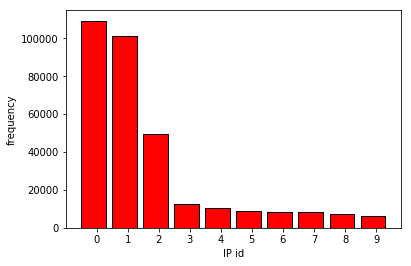

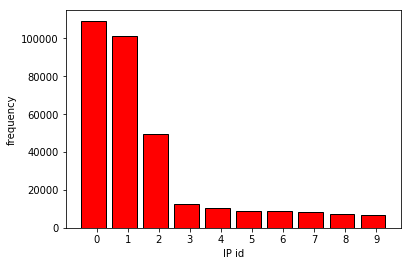

Itersection area:  0.99895624210545


In [11]:
most_freq_sketch_df = df[['SrcIPAddr','freq']].sort_values(['freq'], ascending=False).head(10)
most_freq_sketch = list(zip(np.reshape(most_freq_sketch_df['SrcIPAddr'].values, -1), np.reshape(most_freq_sketch_df['freq'].values, -1)))

calc_error(most_freq_ips, most_freq_sketch)